Looking for the most likely cause of the decrease in Nea. % over the last 10 thousand years.

This is the time period for which we have 6 higher coverage EMHs, all from around 8 kya.

Main idea - if we restrict to super-neutral sites and we see shift in the distribution of Nea. allele frequencies, this is an evidence of migration.

If we see a significant shift at non-neutral sites *beyond* of what is observed on the super-neutral sites, this can be interpreted as selection.

*Why would this work?* After > 40k years after introgression, the individual blocks should be broken down enough so that we can stop worrying about linkage so much. We can therefore have a better idea of which SNPs are super-neutral, compared to early EMHs where, due to longer haplotypes, filtering for superneutral SNPs is problematic (i.e. how far from the informative site we want to filter potential conserved regions?)

**TODO:** Calculate the expected length of Nea. haplotype over time to justify this.

**TODO**: Would it make sense to use the BAM files of the later EMHs and aggregate all the available reads to have a better idea of the actual Nea. introgressed allele frequencies or would it be too much effort?

In [1]:
suppressPackageStartupMessages({
    library(tidyverse);
    library(stringr);
    library(magrittr);
    library(modelr);
    library(broom);
    library(purrr)
})

source("../R/utils.R")

In [2]:
files <- list.files("../clean_data/annotations/", pattern="priPhCons__100000bp.bed", full.names=TRUE)

window_avgs_long <- lapply(files, function(f) {
    read.table(f, header=FALSE) %>%
        .[1:4] %>%
        setNames(c("chrom", "start", "end", "value")) %>%
        mutate(track=str_replace(basename(f), ".bed", ""))
}) %>%
    bind_rows %>%
    rename(pos=end) %>% 
    select(-start)

window_avgs_wide <- spread(window_avgs_long, track, value)

In [3]:
suppressMessages(
    cadd_wide <-
        load_annotations("../clean_data/annotations.tsv") %>%
        select(chrom, pos, bStatistic, priPhCons, Consequence, AnnoType)
)

Warning message:
“673 parsing failures.
 row            col               expected  actual
2136 mapAbility35bp no trailing characters .5     
4607 mapAbility35bp no trailing characters .333333
5028 mapAbility35bp no trailing characters .5     
5379 mapAbility35bp no trailing characters .5     
5819 mapAbility35bp no trailing characters .5     
.... .............. ...................... .......
See problems(...) for more details.
”

In [4]:
all_annots_wide <- inner_join(window_avgs_wide, cadd_wide)

Joining, by = c("chrom", "pos")


In [5]:
colnames(all_annots_wide)[3:ncol(all_annots_wide)]

[1] "priPhCons__100000bp" "bStatistic"          "priPhCons"          
[4] "Consequence"         "AnnoType"

In [6]:
table(all_annots_wide$AnnoType)


   CodingTranscript          Intergenic NonCodingTranscript   RegulatoryFeature 
               8275              440179                8398              100604 
         Transcript 
             387901 

In [7]:
suppressMessages({

# read processed SNP tables of aDNA samples and SGDP individuals,
# merge them and intersect them with the annotations data
all_snps <- load_dataset("../clean_data/ice_age.tsv",
                         "../clean_data/sgdp.tsv",
                         "../clean_data/archaics.tsv",
                         filter_damage=FALSE,
                         metadata_path="../raw_data/10_24_2014_SGDP_metainformation_update.txt",
                         random_sample=F) %>%
    mutate(site_id=paste0(chrom, "_", pos)) %>%
    inner_join(all_annots_wide) %>% 
    mutate(AnnoType=as.factor(AnnoType))

# process the SGDP metainformation table
sgdp_info <-
  load_sgdp_info("../raw_data/10_24_2014_SGDP_metainformation_update.txt") %>%
  mutate(name=str_replace(name, "^S_", "")) %>%
  filter(name %in% colnames(all_snps)) %>%
  mutate(age=0) %>%
  rename(pop=Region) %>%
  filter(pop == "WestEurasia") %>%
  mutate(pop="present_Europe") %>% 
  filter(! Country %in% c('Iran', 'Iraq', 'Jordan', 'Israel(Central)',
                          'Israel(Carmel)', 'Israel(Negev)', 'Israel', 'Tajikistan', 'Turkey', 'Yemen',
                          'Abkhazia', 'Armenia'))

emh_info <- # filter out high C-T samples (mainly non-UDG treated ones and weird library preps)
  read_delim("../clean_data/ages.txt", delim=" ") %>%
  mutate(pop="EMH_Europe") %>%
  filter(name %in% colnames(all_snps),
         ! name %in% c("AfontovaGora3", "GoyetQ116_1", "Kotias", "Oase1", "Satsurblia", "Villabruna"))

samples_info <-
  bind_rows(emh_info, sgdp_info) %>%
  mutate(post_admixture=55000 - age,
         pop=as.factor(pop)) %>%
  filter(age < 10000, name != "Stuttgart") # filter out Stuttgart, which is known to have basal Eurasian ancestry

})

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”Warning message in one_of(sgdp_info$name):
“Unknown variables: `S_Australian_1`, `S_Australian_5`”Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [8]:
samples_info %>% group_by(pop) %>% count()

pop,n
EMH_Europe,5
present_Europe,43


In [9]:
select(filter(samples_info, pop == "EMH_Europe"), name, age, pop)

name,age,pop
Karelia,8375,EMH_Europe
Loschbour,8050,EMH_Europe
LaBrana1,7815,EMH_Europe
Hungarian_KO1,7660,EMH_Europe
Motala12,7625,EMH_Europe


In [10]:
select(filter(samples_info, pop == "present_Europe"), name, age, pop, Country)

name,age,pop,Country
Abkhasian_2,0,present_Europe,Russia
Adygei_1,0,present_Europe,Russia(Caucasus)
Adygei_2,0,present_Europe,Russia(Caucasus)
Albanian_1,0,present_Europe,Albania
Basque_1,0,present_Europe,France
Basque_2,0,present_Europe,France
Bergamo_2,0,present_Europe,Italy(Bergamo)
Bulgarian_1,0,present_Europe,Bulgaria
Bulgarian_2,0,present_Europe,Bulgaria
Chechen_1,0,present_Europe,Russia


Filter SNPs for early/present-day  European samples only:

In [11]:
all_snps %<>% select(c(site_id,
                       one_of(as.character(samples_info$name)),
                       AnnoType, priPhCons__100000bp))

In [12]:
head(all_snps)

site_id,Karelia,Loschbour,LaBrana1,Hungarian_KO1,Motala12,Abkhasian_2,Adygei_1,Adygei_2,Albanian_1,⋯,Russian_1,Russian_2,Sardinian_1,Sardinian_2,Spanish_1,Spanish_2,Tuscan_1,Tuscan_2,AnnoType,priPhCons__100000bp
1_847983,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,NonCodingTranscript,0.047667
1_853089,0,0,0,NA,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,NonCodingTranscript,0.049807
1_853596,NA,0,0,NA,NA,0,0,0,0,⋯,0,0,0,0,0,0,0,0,NonCodingTranscript,0.049866
1_854793,0,0,0,NA,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,NonCodingTranscript,0.049938
1_867552,0,0,0,NA,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,Intergenic,0.047507
1_871401,NA,0,0,NA,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,RegulatoryFeature,0.045560


Create a lookup table of sample population assignments:

In [13]:
pop_table <- samples_info$pop
names(pop_table) <- samples_info$name

Convert SNP data for each sample into a long format:

In [14]:
sites <-
    gather(all_snps, sample, allele, -site_id, -AnnoType, -priPhCons__100000bp) %>%
    mutate(sample=as.factor(sample),
           pop=pop_table[sample],
           allele=ifelse(allele == 0, 0, ifelse(allele == 1, 0.5, ifelse(allele == 2, 1, NA))))

In [15]:
str(sites)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	23232768 obs. of  6 variables:
 $ site_id            : chr  "1_847983" "1_853089" "1_853596" "1_854793" ...
 $ AnnoType           : Factor w/ 5 levels "CodingTranscript",..: 3 3 3 3 2 4 5 5 4 5 ...
 $ priPhCons__100000bp: num  0.0477 0.0498 0.0499 0.0499 0.0475 ...
 $ sample             : Factor w/ 48 levels "Abkhasian_2",..: 30 30 30 30 30 30 30 30 30 30 ...
 $ allele             : num  0 0 NA 0 0 NA NA NA 0 NA ...
 $ pop                : Factor w/ 2 levels "EMH_Europe","present_Europe": 2 2 2 2 2 2 2 2 2 2 ...
  ..- attr(*, "names")= chr  "Hungarian_1" "Hungarian_1" "Hungarian_1" "Hungarian_1" ...


Calculate the SFS of introgressed alleles at each available time point

In [82]:
sfs <- group_by(sites, pop, site_id, AnnoType, priPhCons__100000bp) %>%
    summarise(f=mean(allele, na.rm=TRUE)) %>% 
    filter(!is.nan(f)) %>%
    ungroup

In [83]:
head(sfs)

pop,site_id,AnnoType,priPhCons__100000bp,f
EMH_Europe,1_100002713,Intergenic,0.112185,0.2
EMH_Europe,1_100002991,Intergenic,0.112806,0.2
EMH_Europe,1_100010434,RegulatoryFeature,0.116289,0.2
EMH_Europe,1_100014490,RegulatoryFeature,0.114463,0.2
EMH_Europe,1_100022545,Intergenic,0.114422,0.2
EMH_Europe,1_100022576,Intergenic,0.114453,0.2


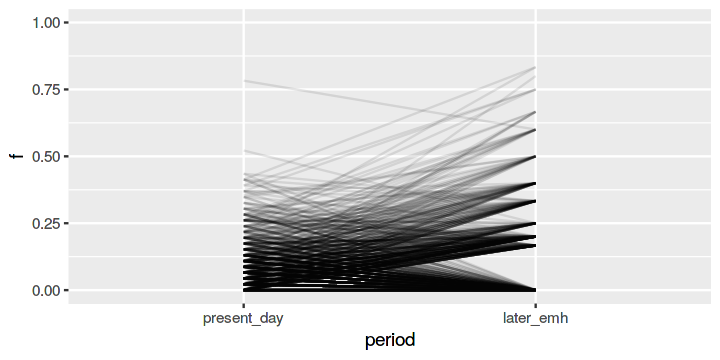

In [33]:
filter(sample_n(sfs, 100000),
       period != "old_emh") %>% 
ggplot(aes(period, f, group=site_id)) + geom_line(alpha=0.1) + ylim(0, 1)

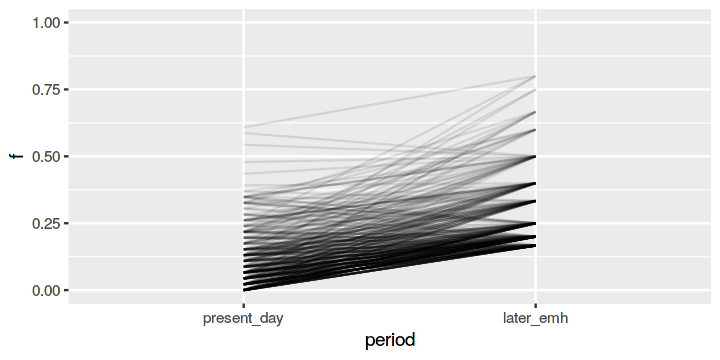

In [34]:
filter(sample_n(sfs, 100000),
       period != "old_emh",
       period == "present_day" | (period == "later_emh" & (f > 0 & f < 1.0))) %>% 
ggplot(aes(period, f, group=site_id)) + geom_line(alpha=0.1) + ylim(0, 1)

In [36]:
sfs_shift <-
    spread(sfs, period, f) %>%
    mutate(freq_shift=present_day - later_emh)

In [37]:
head(sfs_shift)

site_id,AnnoType,priPhCons__100000bp,present_day,later_emh,freq_shift
1_100002713,Intergenic,0.112185,0.04347826,0.00,0.04347826
1_100002991,Intergenic,0.112806,0.06521739,0.25,-0.18478261
1_100010434,RegulatoryFeature,0.116289,0.04347826,0.25,-0.20652174
1_100014490,RegulatoryFeature,0.114463,0.10869565,0.00,0.10869565
1_100022545,Intergenic,0.114422,0.06521739,0.25,-0.18478261
1_100022576,Intergenic,0.114453,0.06521739,0.00,0.06521739


## Genome annotation - coding/regulatory/intergenic

In [38]:
options(repr.plot.width=7, repr.plot.height=4)

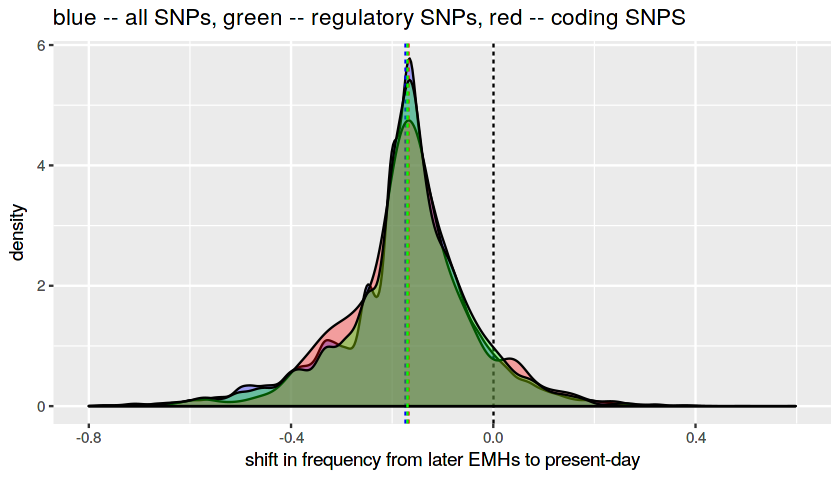

In [49]:
seg_in_emh <- filter(sfs_shift, later_emh > 0, later_emh < 1)

ggplot() +
    geom_vline(xintercept=0, linetype=2, color="black") +

    geom_density(data=filter(seg_in_emh, AnnoType == "Intergenic"), aes(freq_shift), alpha=1/3, fill="blue") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "Intergenic")$freq_shift), linetype=2, color="blue") +

    geom_density(data=filter(seg_in_emh, AnnoType == "CodingTranscript"), aes(freq_shift), alpha=1/3, fill="red") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "CodingTranscript")$freq_shift), linetype=2, color="red") +

    geom_density(data=filter(seg_in_emh, AnnoType == "RegulatoryFeature"), aes(freq_shift), alpha=1/3, fill="green") +
    geom_vline(xintercept=mean(filter(seg_in_emh, AnnoType == "RegulatoryFeature")$freq_shift), linetype=2, color="green") +

    xlab("shift in frequency from later EMHs to present-day") +
    ggtitle("blue -- all SNPs, green -- regulatory SNPs, red -- coding SNPS")

In [42]:
summary(seg_in_emh$freq_shift)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-0.8333 -0.2261 -0.1667 -0.1703 -0.1014  0.5978 

## phastCons-based super-neutrality

In [63]:
(quantiles <- list(
    q5=quantile(all_snps$priPhCons__100000bp, probs=c(0.05, 0.95), na.rm=TRUE),
    q2=quantile(all_snps$priPhCons__100000bp, probs=c(0.02, 0.98), na.rm=TRUE),
    q1=quantile(all_snps$priPhCons__100000bp, probs=c(0.01, 0.99), na.rm=TRUE)
))

$q5
      5%      95% 
0.065137 0.190970 

$q2
       2%       98% 
0.0540150 0.2183012 

$q1
        1%        99% 
0.04460688 0.24103436

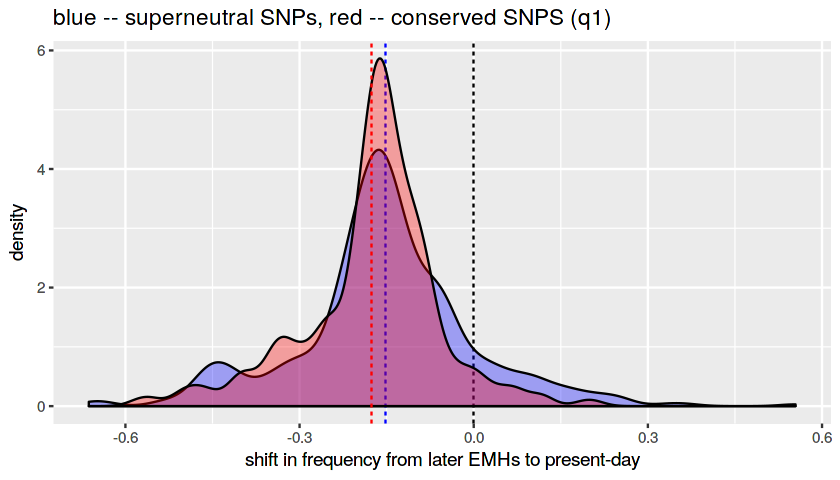

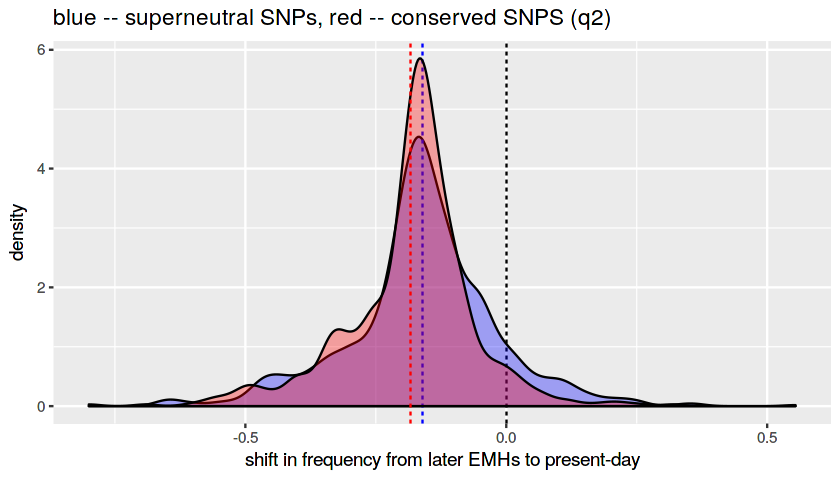

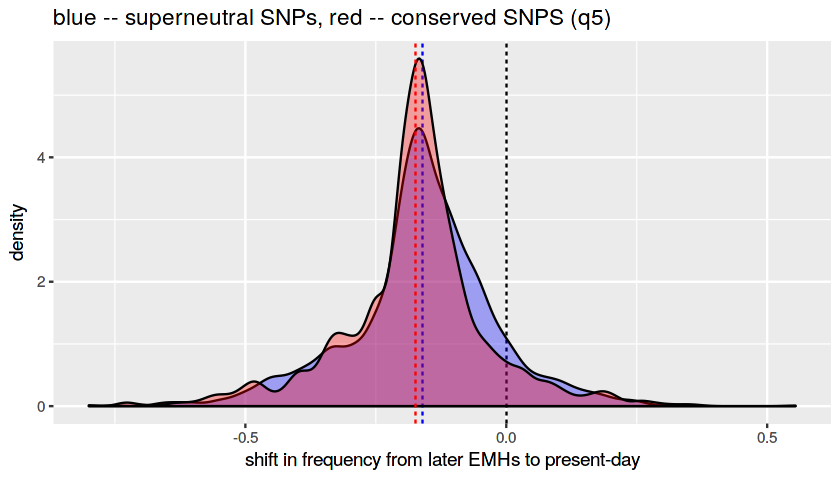

In [75]:
seg_in_emh <- filter(sfs_shift, later_emh > 0, later_emh < 1)

for (q in c("q5", "q2", "q1")) {
    print(
        ggplot() +
            geom_vline(xintercept=0, linetype=2, color="black") +

            geom_density(data=filter(seg_in_emh, priPhCons__100000bp < quantiles[[q]][1]), aes(freq_shift), alpha=1/3, fill="blue") +
            geom_vline(xintercept=mean(filter(seg_in_emh, priPhCons__100000bp < quantiles[[q]][1])$freq_shift), linetype=2, color="blue") +

            geom_density(data=filter(seg_in_emh, priPhCons__100000bp > quantiles[[q]][2]), aes(freq_shift), alpha=1/3, fill="red") +
            geom_vline(xintercept=mean(filter(seg_in_emh, priPhCons__100000bp > quantiles[[q]][2])$freq_shift), linetype=2, color="red") +

            xlab("shift in frequency from later EMHs to present-day") +
            ggtitle(paste0("blue -- superneutral SNPs, red -- conserved SNPS (", q, ")"))
    )
}

What is the best test to get a p-value for this analysis?